# Localization windows and spectral analysis

Now that we know how to work with spherical harmonic coefficient and grid classes, let's move on to the other major feature of *pyshtools*: localization windows and spectral analysis. *pyshtools* allows for localized spectral analyses using either spherical-cap localization windows or localization windows constructed from an arbitrary mask. As with our examples in the previous notebook, a single class, `SHWindow`, bundles the relevant *shtools* functions. Here, we will demonstrate how to construct optimal localization windows, and how to obtain localized spectral estimates for arbitrary regions on the sphere.


## Spherical cap localization windows

In this example, we will make use of a pathological data set. In particular, we will construct a function on the sphere whose power spectrum is different in the northern and southern hemispheres. First, import the standard modules:

In [1]:
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np
import pyshtools

Next, create two grids using random coefficients that have power spectra following power laws of -2 and -3, up to and including degree 300:

In [2]:
ldata = 300
degrees = np.arange(ldata+1, dtype=float)
degrees[0] = np.inf

power_north = degrees**(-2)
power_south = degrees**(-3)

clm_north = pyshtools.SHCoeffs.from_random(power_north)
grid_north = clm_north.expand()

clm_south = pyshtools.SHCoeffs.from_random(power_south)
grid_south = clm_south.expand()

Next, create a new grid that contains data from the northern hemisphere of one grid and the southern hemisphere of the other. To avoid modifying the original grids, we create a copy of the first grid and replace half the hemisphere with a copy of the other:

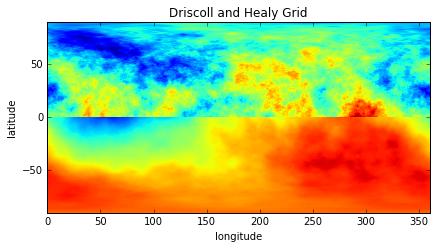

In [3]:
grid = pyshtools.SHGrid.from_array(grid_north.data.copy())

nlat = grid_north.nlat
grid.data[nlat//2:nlat+1,:] = grid_south.data[nlat//2:nlat+1,:].copy()

fig, ax = grid.plot_rawdata()
clm = grid.expand()

Here, we made use of the grid attribute `nlat`, which is the number of rows of the gridded data, and we modified the raw gridded data for `grid` that is stored in the `data` class attribute.

Next, let's construct some spherical-cap localization windows. This is done using the constructor `from_cap()` that is associated with the `SHWindow` class. The other option, as we will demonstrate later, is `from_mask()` and takes as input a user defined mask. For spherical-cap windows, we need to specify both the angular radius of the cap and its spherical harmonic bandwidth, and for this example we will use an angular radius of 30 degrees and a bandwidth of 29.

In [4]:
capwin = pyshtools.SHWindow.from_cap(theta=30., lwin=29)

This command calculates the spherical harmonic coefficients of the spherical cap windows along with their associated angular orders and concentration factors. If you ever need to access these directly, they are stored in the class attributes `tapers`, `orders` and `eigenvalues.` By default, `theta` should be provided in degrees, but this can be input in radians by specifying the optional parameter `theta_degrees=False`. If you are curious to see what these windows look like, you can plot them using the built in method `plot_windows()`. Let's plot the first 35:

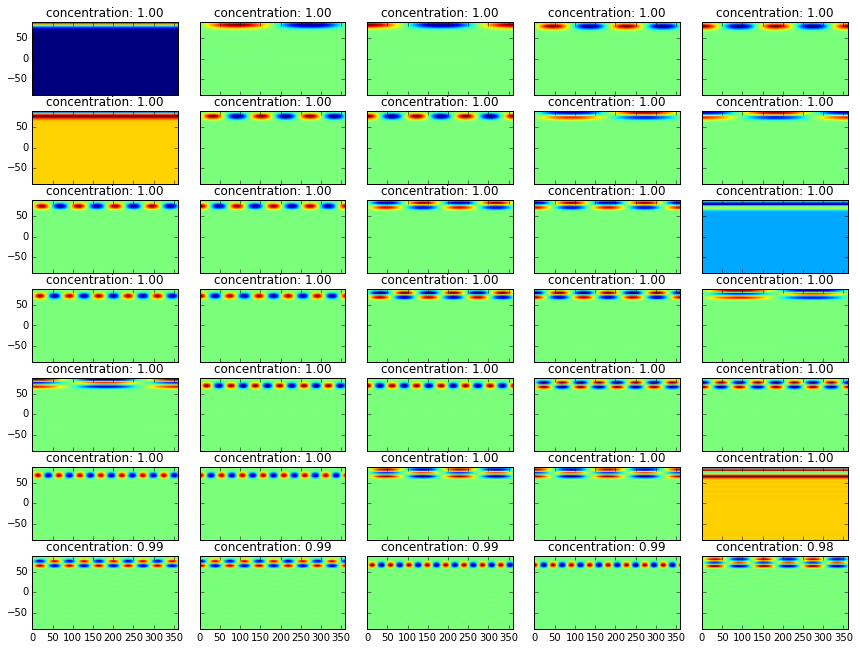

In [5]:
fig, axes = capwin.plot_windows(35)

As is seen, the windows are centered at the north pole, the concentration factor is noted above the window, and almost all of these windows are very well localized. If you want to know how many windows have concentration factors larger than a specified value, you can use the method `get_k()`:

In [6]:
capwin.get_k(0.99)

34

If you are really curious about the windows, you can return gridded maps of individual windows using the methods `get_grid()` and `return_grid()`, you can return the spherical harmonic coefficients of individual windows using `get_coeffs()` and `return_coeffs()`, and you can also return as a numpy array the power spectra of one or more windows using the method `get_powerperdegree()`. If you want to plot the power spectra of the windows, this can be done using the built in method `plot_powerspectra()`:

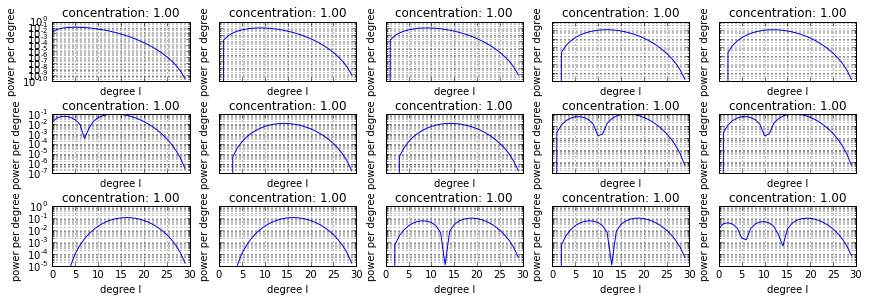

In [7]:
fig, axes = capwin.plot_powerspectra(15)

In general, we will not perform localized spectral analyses at the north pole, so let's rotate the windows so that they are centered at 45 degrees north and 90 degrees east. This is easily accomplished using the `rotate()` method. To speed things up, we will rotate only the first 50 best localized windows, and not all 900 of them:

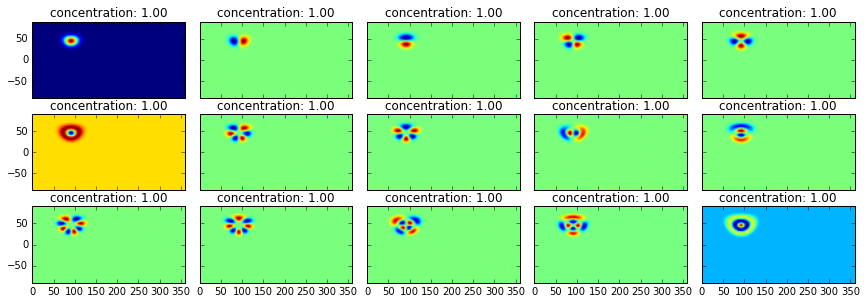

In [8]:
capwin.rotate(clat=45., clon=90., nwinrot=50)

fig, axes = capwin.plot_windows(15)

In rotating the windows, the spherical harmonic coefficients of the initial `tapers` centered at the north pole are not modified, but a second set of rotated coefficients are created and stored in the attribute `coeffs`. If you ever forget how you constructed your windows, you can always use the `info()` method to print out all the metadata:

In [9]:
capwin.info()

kind = 'cap'
theta = 30.000000 degrees
lwin = 29
nwin = 900
clat = 45.000000 degrees
clon = 90.000000 degrees
nwinrot = 50
dj_matrix is stored
Taper weights are not set.


Next, let's calculate the localized power spectrum at two different locations, one in the northern hemisphere and the other in the southern hemisphere. We will use all 34 windows that have concentration factors greater than 0.99:

In [10]:
k = capwin.get_k(0.99)

mtse_north, sd_north = capwin.get_multitaperpowerspectrum(clm, k)
mtse_south, sd_south = capwin.get_multitaperpowerspectrum(clm, k, clat=-55., clon=90.)

If you don't provide the central latitude and longitude of the analysis with the parameters `clat` and `clon`, the coefficients that were created previously using the `rotate()` method will be employed. If these coefficients are not available, the analysis will be performed at the north pole.

`get_multitaperpowerspectrum` returns a power spectrum whose maximum degree is `ldata - lwin`. This is because localized degrees beyond this limit depend upon coefficients of the global data beyond `ldata`, and these are **not known**. If the global function was truly zero beyond `ldata`, you could simply construct the spherical harmonic coefficients of `clm` to have zeros beyond that degree.

When a function is multiplied by a window, the power spectrum of the localized function is modified. For the case of stationary and random data, the expectation of this biasing effect can be estimated using two methods. First, we could calculate the "coupling matrix" using the method `get_couplingmatrix()`. The expectation of the windowed power spectrum is then simply the multiplication of this matrix by the global spectrum. If you are interested, you can plot the coupling matrix using the built in method `plot_couplingmatrix()`:

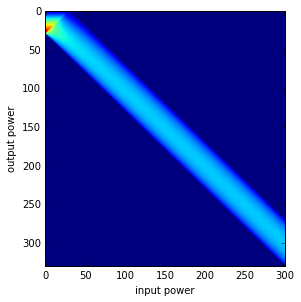

In [11]:
fig, ax = capwin.plot_couplingmatrix(ldata)

Here, however, we will estimate the expectation of the windowed spectrum using `get_biasedpowerspectrum()` and the global power spectra used to create the data in the northern and southern hemispheres:

In [12]:
power_north_biased = capwin.get_biasedpowerspectrum(power_north, k)
power_south_biased = capwin.get_biasedpowerspectrum(power_south, k)

Note that this function returns a spectrum with a maximum degree `ldata+lwin`. In calculating the expectation of the biased power spectrum from the global spectrum, it is assumed implicitly that the global power spectrum is exactly zero for all degrees greater than `ldata`.

Finally, lets plot the global power spectra, the localized spectra, and the localized expectations. Assuming that the data are unknown above degree `ldata`, we plot only the valid localized spectral estimates up to degree `ldata - lwin`.

[None,
 (1e-08, 1.0),
 (0, 171),

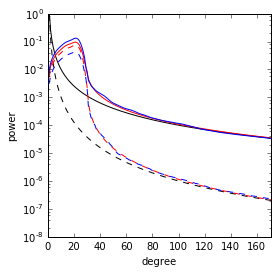

In [13]:
degrees2 = np.arange(ldata+capwin.lwin+1)
degrees3 = np.arange(ldata-capwin.lwin+1)

fig, ax = plt.subplots(1,1)
ax.plot(degrees, power_north, '-k',
        degrees, power_south, '--k',
        degrees2, power_north_biased, '-r',
        degrees2, power_south_biased, '--r',
        degrees3, mtse_north, '-b',
        degrees3, mtse_south, '--b')
ax.set(yscale='log', xlabel='degree', ylabel='power', xlim=(0,200-capwin.lwin), ylim=(1.e-8, 1.))

As is seen, the expectation of the localized spectrum (red) is significantly biased at low degrees in comparison to the unwindowed global fields. This is not necessarily a problem, because this effect is quantifiable. The actual localized power spectrum (blue) is found to closely resemble the expected value, especially for degrees greater than the window bandwidth of 29. 

In this example, we calculated only the localized power spectrum of a single function. If you were interested in the localized cross-power spectrum of two functions, this could be caluculated using the method `get_multitapercrosspowerspectrum()`.

## Arbitrary localization windows

We next demonstrate how to perform a localized spectral analysis over an irregular region. For this example, we will first create a function whose power spectrum is different over the oceans and landmass of Earth, we will then calculate windows that localize these two regions, and finally we will perform a multitaper spectral analysis similar to what we did with the spherical cap localization windows above.

First, let's read in the spherical harmonic coefficients of Earth's topography (referenced to mean sea level):


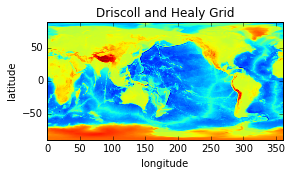

In [14]:
topo_coeffs = pyshtools.SHCoeffs.from_file('../ExampleDataFiles/srtmp300.msl', 300)
topo = topo_coeffs.expand()
fig, ax = topo.plot_rawdata()

Next, create a boolean mask that is `True` for elevations that are greater than zero:

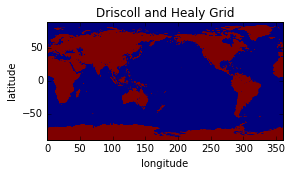

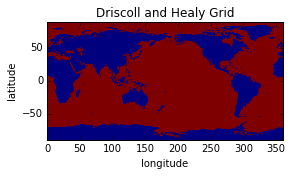

In [15]:
land_mask = pyshtools.SHGrid.from_array(topo.data > 0)
ocean_mask = pyshtools.SHGrid.from_array(topo.data <= 0)

fig, ax = land_mask.plot_rawdata()
fig2, ax2 = ocean_mask.plot_rawdata()

Constructing localization windows from a boolean mask is simple using the `from_mask()` constructor of the `SHWindow` class. Here, we will use a spherical harmonic bandwidth of 30, and then plot maps and power spectra of the first 20 windows that are concentrated on land:

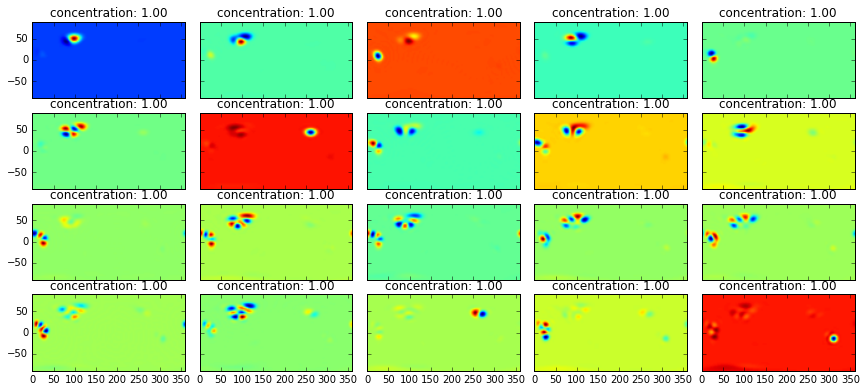

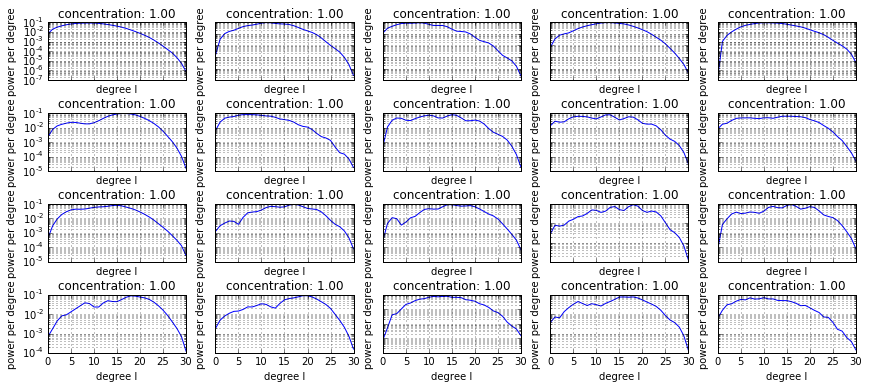

In [16]:
land_windows = pyshtools.SHWindow.from_mask(land_mask.data, 30)
ocean_windows = pyshtools.SHWindow.from_mask(ocean_mask.data, 30)

fig, axes = land_windows.plot_windows(20)
fig, axes = land_windows.plot_powerspectra(20)

To demonstrate that these windows actually concentrate their power over the land and oceans, we next plot the cumulative energy of all windows that have concentration factors greater than 0.99. In this case, because the surface area of the oceans is larger than that of the land, there are many more ocean windows than land windows.

k_land = 83
k_ocean = 433


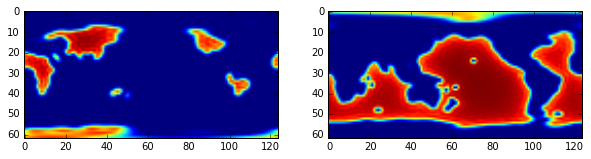

In [17]:
k_land = land_windows.get_k(0.99)
k_ocean = ocean_windows.get_k(0.99)

print('k_land = {:d}'.format(k_land))
print('k_ocean = {:d}'.format(k_ocean))

land_energy = (land_windows.get_grid(0))**2
for i in range(1,k_land):
    land_energy = land_energy + (land_windows.get_grid(i))**2

ocean_energy = (ocean_windows.get_grid(0))**2
for i in range(1,k_ocean):
    ocean_energy = ocean_energy + (ocean_windows.get_grid(i))**2

fig, axes = plt.subplots(1, 2, figsize=(10, 5))
axes[0].imshow(land_energy)
axes[1].imshow(ocean_energy)

Next, let's construct a pathological function that has different power spectra over the oceans and land. In this example, we will make use of the same grids that we constructed for our demonstation using spherical cap localization windows. In particular, the land mass will use the grid constructed from random coefficients with a power spectrum that followed a  power law of exponenent -2, and the oceans will use the grid constructed with a power law exponent of -3.

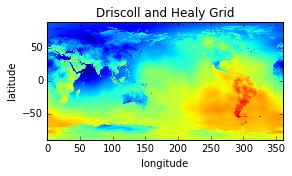

In [18]:
grid_earth = grid_north.copy()
grid_earth.data[topo.data<=0.] = grid_south.data[topo.data<=0.].copy()

clm_earth = grid_earth.expand()
fig, ax = grid_earth.plot_rawdata()

Finally, we calculate localized power spectra over the land and oceans, as well as the expection of the windowed spectra. For demonstration purposes, we will use the same number of localization windows for both regions. 

[None,
 (1e-08, 1.0),
 (0, 170),

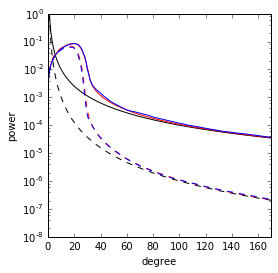

In [19]:
mtse_land, sd_land = land_windows.get_multitaperpowerspectrum(clm_earth, k_land)
mtse_ocean, sd_ocean = ocean_windows.get_multitaperpowerspectrum(clm_earth, k_land)

power_land_biased = land_windows.get_biasedpowerspectrum(power_north, k_land)
power_ocean_biased = ocean_windows.get_biasedpowerspectrum(power_south, k_land)

degrees2 = np.arange(ldata+land_windows.lwin+1)
degrees3 = np.arange(ldata-land_windows.lwin+1)

fig, ax = plt.subplots(1,1)
ax.plot(degrees, power_north, '-k',
        degrees, power_south, '--k',
        degrees2, power_land_biased, '-r',
        degrees2, power_ocean_biased, '--r',
        degrees3, mtse_land, '-b',
        degrees3, mtse_ocean, '--b')
ax.set(yscale='log', xlabel='degree', ylabel='power', xlim=(0,200-land_windows.lwin), ylim=(1.e-8, 1.))

As with our example using spherical cap localization windows, the localized power spectra (blue) over the oceans and land match closely their theoretical expectations (red). Both of these are significantly biased from the unwindowed global spectra (black) at low degrees.